<a href="https://colab.research.google.com/github/Fpinto99/Time_Series/blob/main/EX_Pratico2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.stattools import adfuller

gafa = pd.read_csv('gafa_stock.csv')
aus_retail = pd.read_csv('aus_retail.csv')
global_economy = pd.read_csv('global_economy.csv')
aus_production = pd.read_csv('aus_production.csv')
ansett = pd.read_csv('ansett.csv')

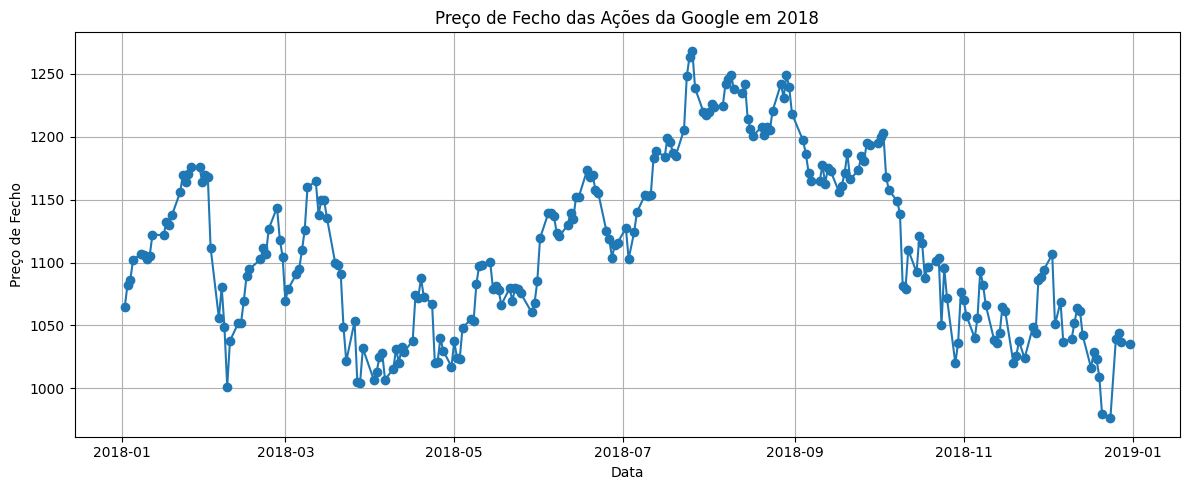

In [2]:
gafa["Date"] = pd.to_datetime(gafa["Date"])

google_2018 = gafa[(gafa["Symbol"] == "GOOG") & (gafa["Date"].dt.year == 2018)]

plt.figure(figsize=(12, 5))
plt.plot(google_2018["Date"], google_2018["Close"], marker='o', linestyle='-')
plt.title("Preço de Fecho das Ações da Google em 2018")
plt.xlabel("Data")
plt.ylabel("Preço de Fecho")
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

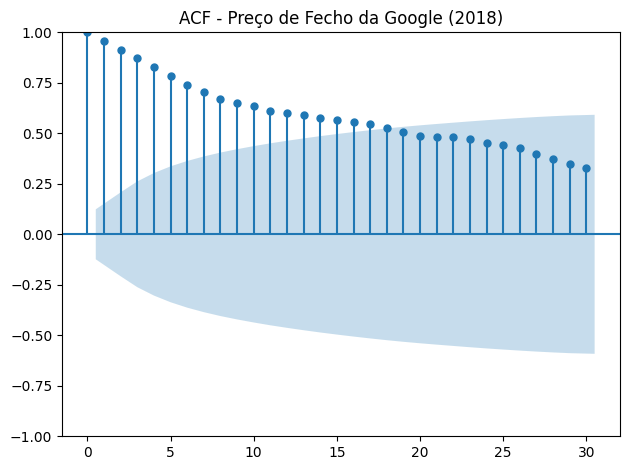

(np.float64(-2.21586221176698),
 np.float64(0.20053884135200367),
 3,
 247,
 {'1%': np.float64(-3.457105309726321),
  '5%': np.float64(-2.873313676101283),
  '10%': np.float64(-2.5730443824681606)},
 np.float64(2058.94491863008))

In [3]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 4))
plot_acf(google_2018["Close"], lags=30)
plt.title("ACF - Preço de Fecho da Google (2018)")
plt.tight_layout()
plt.show()

adf_result = adfuller(google_2018["Close"])
adf_result

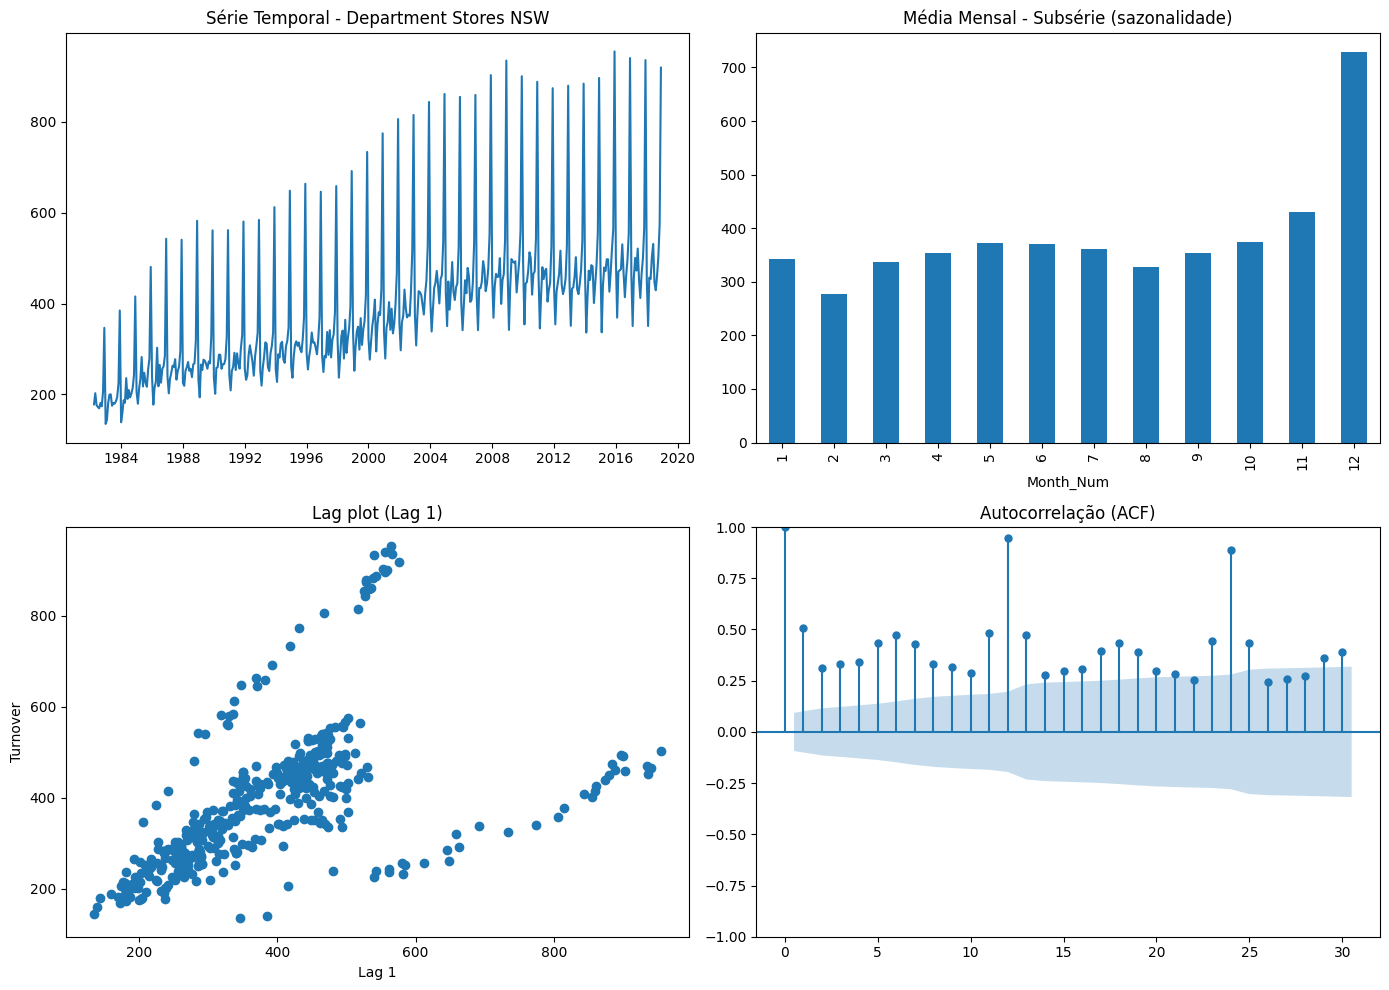

In [5]:
aus_retail["Month"] = pd.to_datetime(aus_retail["Month"])

serie = aus_retail[
    (aus_retail["State"] == "New South Wales") &
    (aus_retail["Industry"] == "Department stores")
].copy()

# Criação das colunas de lag
serie["Sales_Lag1"] = serie["Turnover"].shift(1)

# Gráficos: Temporal, Subseries, Lag, ACF
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Série temporal
axs[0, 0].plot(serie["Month"], serie["Turnover"])
axs[0, 0].set_title("Série Temporal - Department Stores NSW")

# média por mês
serie["Month_Num"] = serie["Month"].dt.month
serie.groupby("Month_Num")["Turnover"].mean().plot(kind='bar', ax=axs[0, 1])
axs[0, 1].set_title("Média Mensal - Subsérie (sazonalidade)")

# Lag plot
axs[1, 0].scatter(serie["Sales_Lag1"], serie["Turnover"])
axs[1, 0].set_title("Lag plot (Lag 1)")
axs[1, 0].set_xlabel("Lag 1")
axs[1, 0].set_ylabel("Turnover")

# ACF
plot_acf(serie["Turnover"].dropna(), lags=30, ax=axs[1, 1])
axs[1, 1].set_title("Autocorrelação (ACF)")

plt.tight_layout()
plt.show()

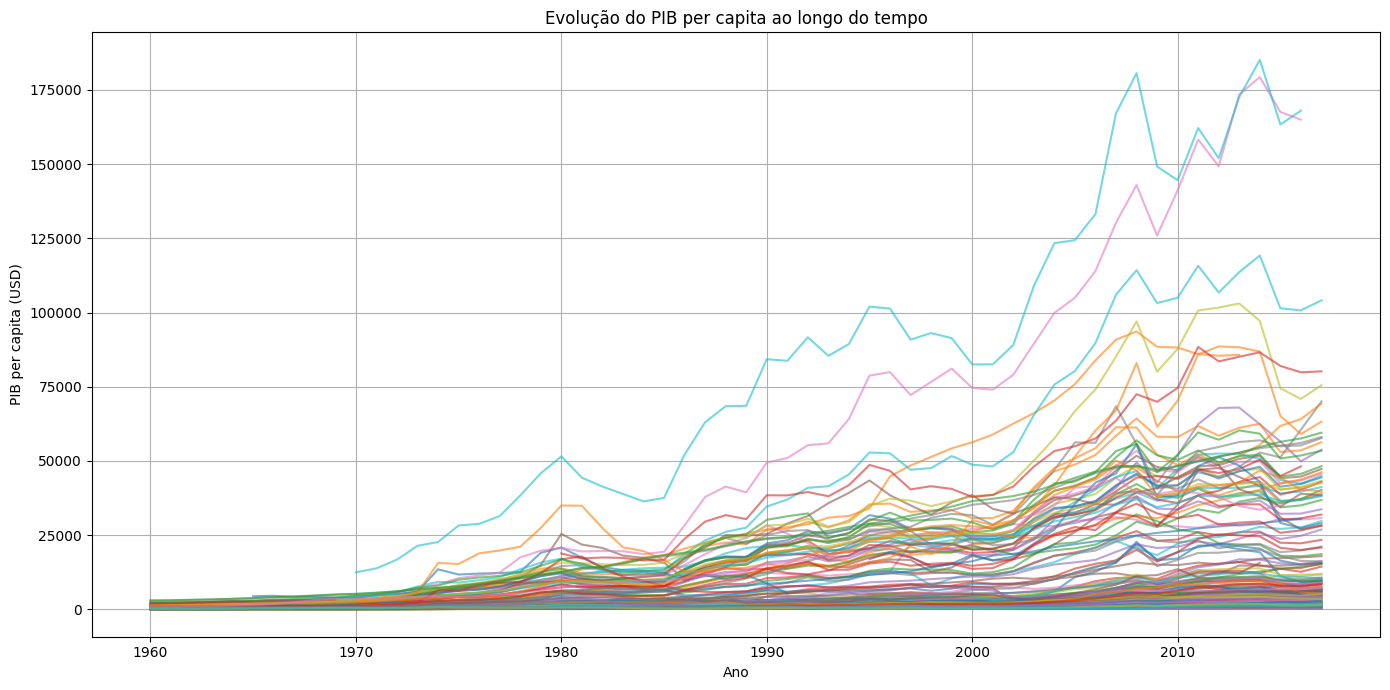

,9502
Country,Monaco
Year,2014
GDP_per_capita,185152.527227


In [6]:
global_economy["GDP_per_capita"] = global_economy["GDP"] / global_economy["Population"]

# Agrupamento por país, ano e GDP
gdp_pivot = global_economy.pivot_table(index="Year", columns="Country", values="GDP_per_capita")

# Selecionar os países com dados mais completos i.e menos NaN possíveis
top_countries = gdp_pivot.columns[gdp_pivot.isna().mean() < 0.2]

# Plot dos paises que selecionamos
plt.figure(figsize=(14, 7))
gdp_pivot[top_countries].plot(ax=plt.gca(), legend=False, alpha=0.6)
plt.title("Evolução do PIB per capita ao longo do tempo")
plt.ylabel("PIB per capita (USD)")
plt.xlabel("Ano")
plt.grid(True)
plt.tight_layout()
plt.show()

#Maior pís com GDP per capita
max_gdp = global_economy.loc[global_economy["GDP_per_capita"].idxmax()]
max_gdp[["Country", "Year", "GDP_per_capita"]]

In [8]:
from scipy import stats
# Remoção de valores nulos e negativos pois o Box-Cox só trabalha com x>0
serie_boxcox = serie["Turnover"].dropna()
serie_boxcox = serie_boxcox[serie_boxcox > 0]

# Aplicar transformação Box-Cox e obter o lambda
boxcox_transformed, lambda_bc = stats.boxcox(serie_boxcox)

lambda_bc

np.float64(-0.1222939561520907)

In [9]:
tobacco = aus_production["Tobacco"].dropna()
tobacco = tobacco[tobacco > 0]
_, lambda_tobacco = stats.boxcox(tobacco)

# Economy class passengers - Melbourne para Sydney - ansett
ansett_filtered = ansett[
    (ansett["Airports"] == "MEL-SYD") & (ansett["Class"] == "Economy")
]["Passengers"].dropna()
ansett_filtered = ansett_filtered[ansett_filtered > 0]
_, lambda_melsyd = stats.boxcox(ansett_filtered)

lambda_tobacco, lambda_melsyd

(np.float64(1.4081158422710829), np.float64(1.2501376037023786))

<ipython-input-10-1a88976c9b6c>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  aus_production["Quarter_dt"] = pd.to_datetime(aus_production["Quarter_str"], errors='coerce')


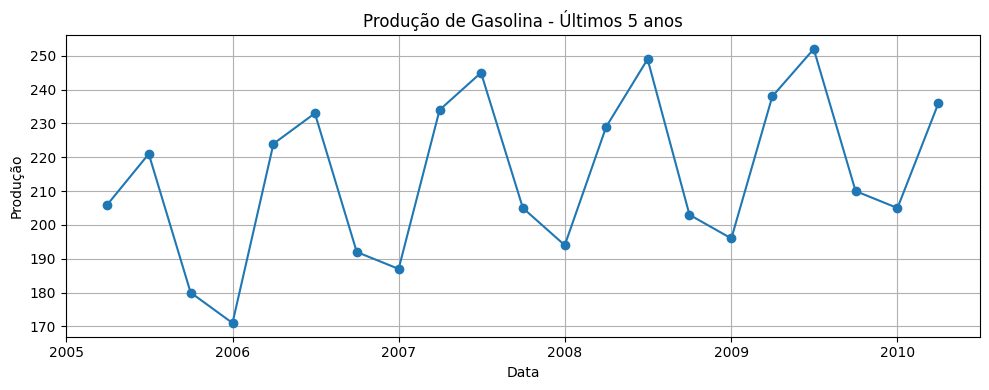

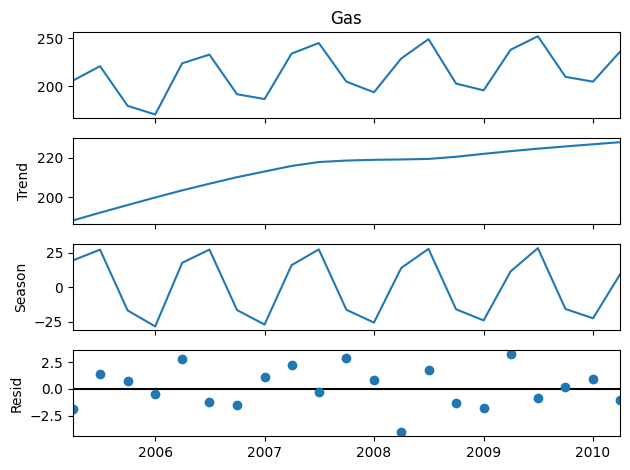

In [10]:
# Converter o formato "1956 Q1" para "1956-01"
quarter_to_month = {"Q1": "01", "Q2": "04", "Q3": "07", "Q4": "10"}
aus_production["Quarter_str"] = aus_production["Quarter"].replace(quarter_to_month, regex=True)
aus_production["Quarter_dt"] = pd.to_datetime(aus_production["Quarter_str"], errors='coerce')

# Agora filtrar os últimos 5 anos
ultima_data = aus_production["Quarter_dt"].max()
cinco_anos_atras = ultima_data - pd.DateOffset(years=5)
gasolina = aus_production[aus_production["Quarter_dt"] >= cinco_anos_atras][["Quarter_dt", "Gas"]].dropna()

# Gráfico da produção de gasolina
plt.figure(figsize=(10, 4))
plt.plot(gasolina["Quarter_dt"], gasolina["Gas"], marker='o')
plt.title("Produção de Gasolina - Últimos 5 anos")
plt.xlabel("Data")
plt.ylabel("Produção")
plt.grid(True)
plt.tight_layout()
plt.show()

# Decomposição STL
stl = STL(gasolina.set_index("Quarter_dt")["Gas"], seasonal=7)
res = stl.fit()
res.plot()
plt.tight_layout()
plt.show()